In [1]:
import config 
import Dataset
from Discriminator import Discriminator
from Generator import Generator
import utils
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchview import draw_graph
import albumentations as A
from albumentations.pytorch import ToTensorV2
import graphviz
import os 
import cv2
from patchify import patchify, unpatchify
graphviz.set_jupyter_format('png')

'svg'

In [2]:
def corp_image(image,patch_size):
    patch_size_x , patch_size_y,channels = patch_size
    if patch_size_x > image.shape[1] or patch_size_y > image.shape[0]:
        raise ValueError("Patch size is larger than image size")
    SIZE_X = (image.shape[1]//patch_size_x)*patch_size_x
    SIZE_Y = (image.shape[0]//patch_size_y)*patch_size_y
    rest_pixels_x = image.shape[1] - SIZE_X
    rest_pixels_y = image.shape[0] - SIZE_Y
    origin_x = rest_pixels_x // 2
    origin_y = rest_pixels_y // 2
    corped_image = image[origin_y:origin_y+SIZE_Y, origin_x:origin_x+SIZE_X]
    return corped_image

# def denormalize(tensor, mean, std):
#     for t, m, s in zip(tensor, mean, std):
#         t.mul_(s).add_(m)
#     return tensor
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t = t*s + m
    return tensor

#transformed_image = transformed_image * 0.5 + 0.5

(512, 512, 3)
tensor([[[0.9216, 0.9529, 0.9686,  ..., 0.6941, 0.6863, 0.6863],
         [0.9137, 0.9216, 0.9294,  ..., 0.6784, 0.6706, 0.6706],
         [0.8745, 0.8824, 0.9059,  ..., 0.6706, 0.6627, 0.6706],
         ...,
         [0.8353, 0.8353, 0.8275,  ..., 0.8039, 0.8275, 0.8196],
         [0.7882, 0.7961, 0.8039,  ..., 0.8039, 0.8431, 0.8588],
         [0.7490, 0.7569, 0.7804,  ..., 0.7961, 0.8118, 0.8196]],

        [[0.8588, 0.8902, 0.9059,  ..., 0.3882, 0.4039, 0.4353],
         [0.8667, 0.8824, 0.8824,  ..., 0.3804, 0.4039, 0.4353],
         [0.8745, 0.8667, 0.8745,  ..., 0.3882, 0.4196, 0.4588],
         ...,
         [0.8118, 0.8196, 0.8588,  ..., 0.8431, 0.8431, 0.8510],
         [0.8510, 0.8353, 0.8431,  ..., 0.8353, 0.8275, 0.8118],
         [0.8510, 0.8196, 0.8039,  ..., 0.8039, 0.8118, 0.7882]],

        [[0.8980, 0.9216, 0.9294,  ..., 0.0667, 0.0824, 0.0902],
         [0.8431, 0.8980, 0.9294,  ..., 0.0902, 0.1137, 0.1216],
         [0.7961, 0.8667, 0.9216,  ..., 0.06

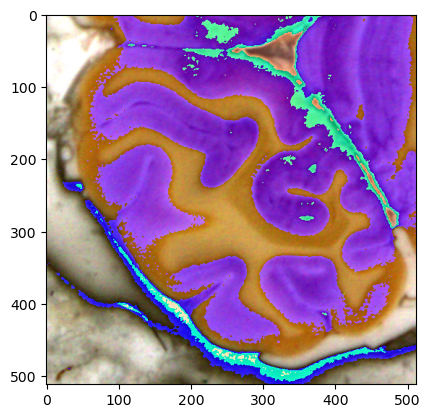

In [3]:
image_path = "/home/gizmoo/Desktop/Seg/Bface/Blockface_RGB_66x66x60um_s841-s1083_234s0047.png"
TEST_TRANSFORM = A.Compose(
    [   
        #A.Resize(width=256, height=256,interpolation=cv2.INTER_NEAREST),
        A.Normalize(
                mean=0.5,
                std=0.5
            ),
        # A.Normalize(
        #         mean=[0.5, 0.5, 0.5],
        #         std=[0.5, 0.5, 0.5],
        #         max_pixel_value=255.0,
        #     ),
        ToTensorV2(),
    ],additional_targets= {"trans":"image"}
)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
corped_image = corp_image(image= image, patch_size=(256,256,3))
# Resize the image to the desired shape
print(corped_image.shape)

transform = TEST_TRANSFORM(image=corped_image)
transformed_image = transform["image"]
print(transformed_image)
#transformed_image = transformed_image * 0.5 + 0.5
transformed_image = denormalize(transformed_image,mean=[0.5,0.5,0.5],std =[0.5,0.5,0.5])
transformed_image = transformed_image.permute(1, 2, 0)
transformed_image = transformed_image * 255.0
transformed_image = transformed_image.numpy().astype(np.uint8)  # Convert tensor to numpy array and change data type
print(transformed_image.shape)
plt.imshow(transformed_image)

In [4]:
#patch_size = (256,256,3)
image_path = "/home/gizmoo/Desktop/BFACE/Masked_BFACE/Result of Blockface_RGB_66x66x60um_s841-s1083_234s0000.png"
checkpoint_file = "/home/gizmoo/Desktop/MA-code/Pix2Pix_RGB/saves/save_20240108_065639/gen.pth.tar"
save_dir = "/home/gizmoo/Desktop/results"
def make_Gen_prediction(image_path,checkpoint_file, save_dir = None):
    image = cv2.imread(image_path,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    patch_size = (256,256,3)
    corped_image = corp_image(image,patch_size)
    image_patches = patchify(corped_image,patch_size,step = patch_size[0])
    print(image_patches.shape)
    model = Generator(in_channels=3 , features=64).to(device = config.DEVICE)
    optimizer = torch.optim.Adam(model.parameters(),lr =config.LEARNING_RATE)
    image_prediction = []
    utils.load_checkpoint(checkpoint_file,model = model ,optimizer=optimizer,lr  = config.LEARNING_RATE)
    #model.load_state_dict(torch.load(weights)[0])
    model.eval()
    for i in range(image_patches.shape[0]):
        for j in range(image_patches.shape[1]):
            patch = image_patches[i,j,:,:].squeeze()
            patch = config.TEST_TRANSFORM(image = patch)["image"]
            print(patch.shape)
            with torch.no_grad():
                patch = patch.unsqueeze(0).to(device = config.DEVICE) 
                prediction = model(patch).squeeze()
                prediction = denormalize(prediction,mean=[0.5,0.5,0.5],std =[0.5,0.5,0.5])
                prediction = prediction.permute(1, 2, 0)
                #plt.imshow(prediction.cpu())
                prediction = prediction * 255.0
                prediction = prediction.cpu().numpy().astype(np.uint8)
                #plt.imshow(prediction)
                image_prediction.append(prediction)
    image_prediction = np.array(image_prediction)
    #print(image_prediction.shape)
    image_prediction = image_prediction.reshape(image_patches.shape[0],image_patches.shape[1],1,patch_size[0], patch_size[1],patch_size[2])
    #print(image_prediction.shape)
    target_image_shape = (512,512,3)
    merged_image = unpatchify(image_prediction,target_image_shape)
    #merged_image = merged_image * 0.5 + 0.5
    #merged_image = merged_image * 255.0
    #merged_image = denormalize(merged_image,mean=[0.5,0.5,0.5],std =[0.5,0.5,0.5])
    #merged_image = merged_image.astype(np.uint8)
    if  save_dir is not None:
        # Ensure the save directory exists
        os.makedirs(save_dir, exist_ok=True)

        # Save the cropped image as an RGB image
        cropped_image_path = os.path.join(save_dir, 'cropped_image.png')
        cv2.imwrite(cropped_image_path, cv2.cvtColor(corped_image, cv2.COLOR_RGB2BGR))

        # Save the merged prediction image as a grayscale image
        merged_image_path = os.path.join(save_dir, 'merged_image.png')
        cv2.imwrite(merged_image_path, cv2.cvtColor(merged_image,cv2.COLOR_RGB2BGR))

    return corped_image, merged_image


x,y = make_Gen_prediction(image_path=image_path, checkpoint_file= checkpoint_file,save_dir= save_dir )

(2, 2, 1, 256, 256, 3)
=> Loading checkpoint
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


=> Loading checkpoint


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

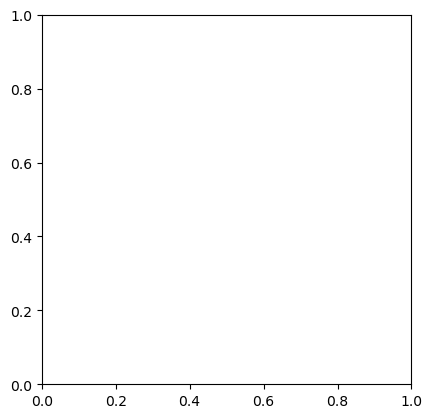

In [8]:
image_path = "/home/gizmoo/Desktop/BFACE/Masked_BFACE/Result of Blockface_RGB_66x66x60um_s841-s1083_234s0000.png"
checkpoint_file = "/home/gizmoo/Desktop/MA-code/Pix2Pix_RGB/saves/save_20240108_065639/gen.pth.tar"
save_dir = "/home/gizmoo/Desktop/results"
def make_GAN_prediction(image_path,checkpoint_file, save_dir =None):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    patch_size = (256,256,3)
    corped_image = corp_image(image,patch_size)
    image_patches = patchify(corped_image,patch_size,step = patch_size[0])
    model = Generator().to(device = config.DEVICE)
    optimizer = torch.optim.Adam(model.parameters(),lr =config.LEARNING_RATE)
    image_prediction = []
    utils.load_checkpoint(checkpoint_file,model = model ,optimizer=optimizer,lr  = config.LEARNING_RATE)
    #model.load_state_dict(torch.load(weights)[0])
    model.eval()
    for i in range(image_patches.shape[0]):
        for j in range(image_patches.shape[1]):
            patch = image_patches[i,j,:,:]
            patch = patch.squeeze()
            patch = config.TEST_TRANSFORM(image = patch)["image"]
            with torch.no_grad():
                patch = patch.unsqueeze(0).to(device = config.DEVICE) 
                prediction = model(patch).squeeze()
                prediction = prediction.permute(1,2,0) 
                plt.imshow(prediction.cpu().numpy())
                print(prediction.shape)
                image_prediction.append(prediction.cpu().numpy())
    #image_prediction = np.array(image_prediction)
    image_prediction = image_prediction.reshape(image_patches.shape[0],image_patches.shape[1],1,*patch_size)
    target_image_shape = (corped_image.shape)
    merged_image = unpatchify(image_prediction,target_image_shape)
    merged_image = denormalize(merged_image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    merged_image = merged_image * 255.0
    merged_image = merged_image.astype(np.uint8)
    if save_dir is not None:
        # Ensure the save directory exists
        os.makedirs(save_dir, exist_ok=True)

        # Save the cropped image as an RGB image
        cropped_image_path = os.path.join(save_dir, 'cropped_image.png')
        cv2.imwrite(cropped_image_path, cv2.cvtColor(corped_image, cv2.COLOR_RGB2BGR))

        # Save the merged prediction image as a grayscale image
        merged_image_path = os.path.join(save_dir, 'merged_image.png')
        cv2.imwrite(merged_image_path, cv2.cvtColor(merged_image, cv2.COLOR_RGB2BGR))

    return corped_image, merged_image
x,y = make_GAN_prediction(image_path=image_path, checkpoint_file= checkpoint_file,save_dir= save_dir )